!kaggle competitions download -c titanic

# Background
Understand the relationship between the circuntances and the outcome, that finished the life of 549 human lifes. What characterized to the people, why they survived and what factors pushed his probabilities to survive are the main question that i going to review in this notebook.

## Project Planning
    * bonus automatic EDA

* Understand the data behavior <p>
  1 Histograms<p>
  2 Value counts <p>
  3 Missing data<p>
  4 correlations of some features
* Explore interesting themes <p>
  1 Rich people survive more?<p>
  2 Female survive more?, what about kids and old people<p>
  3 How the fare payment affects the survival<p>
  4 Your title name affects your chances to survive<p>
  5 Where did you embarked affects your chance to survive<p>
* Feature Engineering
    * Create more features
    * Fill nan values
    * Normalize data
    * Try to categorize data and see what happened ¿is good?
* Preprocess data for numerical and categorical data
* Understand the limitations of the data – imbalance data
* Model tunning
* Model benchmark

# Type of data

### 1 Numerical Data
* Histograms to understand distributions
* Correlations plot
* Pivot tables comparing survival rates

### 2 Categorical Data
* Made barchars to understand balance between classes
* Made pivot tables to understand relationship with survival

In [1]:
from process_data import pre_process_dataset, balancingClasses_Smoteenn, balancingClasses_Smote

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import random
import time
from tqdm import tqdm
import IPython.display as ipd
import seaborn as sns
import itertools
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from sklearn.neighbors import KNeighborsClassifier as KNC
from IPython.display import display # display from IPython.display
import pandas_profiling # library for automatic EDA # pip install pandas-profiling[notebook]
from autoviz.AutoViz_Class import AutoViz_Class

%matplotlib inline
def plot_confusion_matrix(y_true, y_pred, class_names,title="Confusion matrix",normalize=False,onehot = False, size=4):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    if onehot :
        cm = confusion_matrix([y_i.argmax() for y_i in y_true], [y_ip.argmax() for y_ip in y_pred])
    else:
        cm = confusion_matrix(y_true, y_pred)
    figure = plt.figure(figsize=(size, size))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2) if normalize else cm

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "red" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #return figure

In C:\Users\David\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\David\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\David\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\David\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

Imported AutoViz_Class version: 0.0.68. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


In [2]:
DBtrain = pd.read_csv('dataset/train.csv')
DBtest = pd.read_csv('dataset/test.csv')
DBtrain.info(verbose=True)
DBtrain.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

# Dumb Automatic EDA

Plots by pandas_profiling

In [3]:
report_easy = pandas_profiling.ProfileReport(DBtrain)
display(report_easy)

Let's now visualize the plots generated by AutoViz.

Shape of your Data Set: (891, 12)
Classifying variables in data set...
    12 Predictors classified...
        This does not include the Target column(s)
    4 variables removed since they were ID or low-information variables
Number of All Scatter Plots = 3
Time to run AutoViz (in seconds) = 1.509


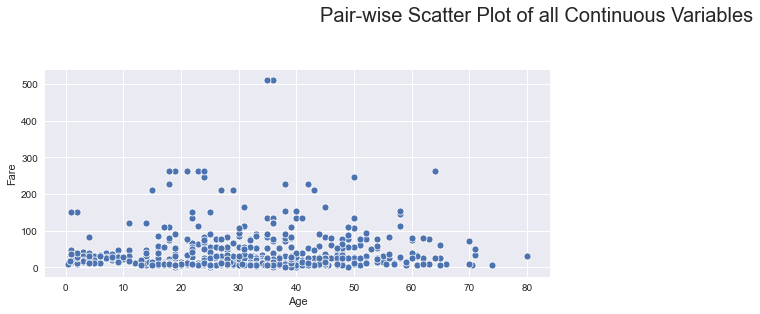

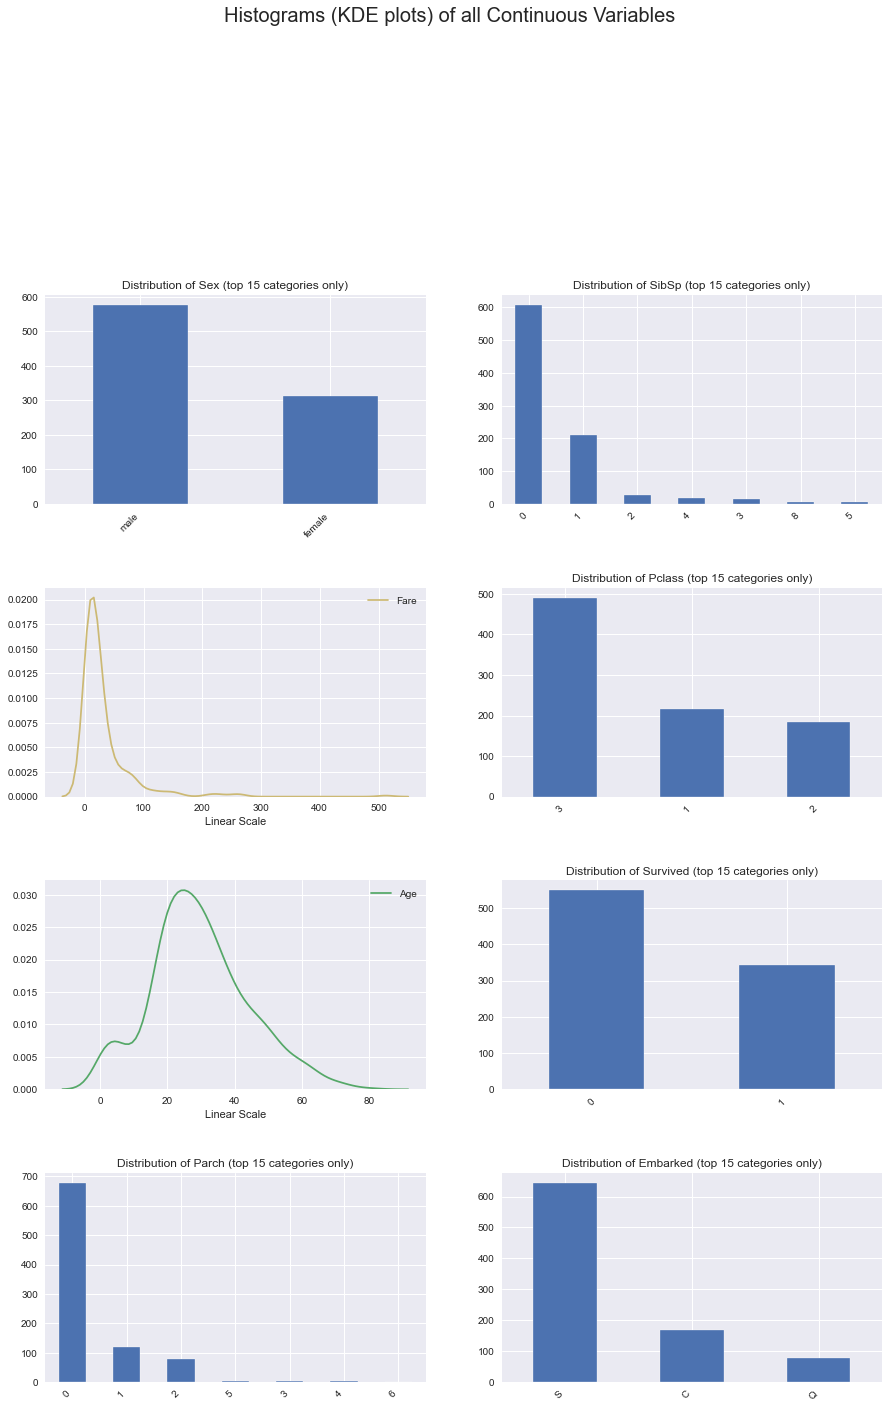

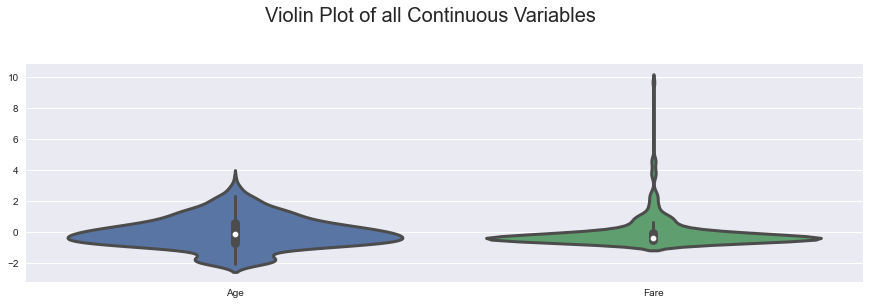

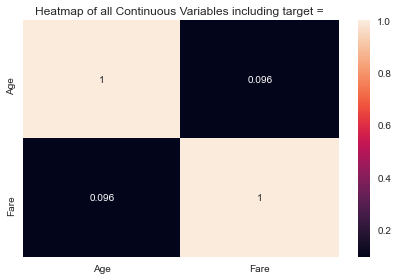

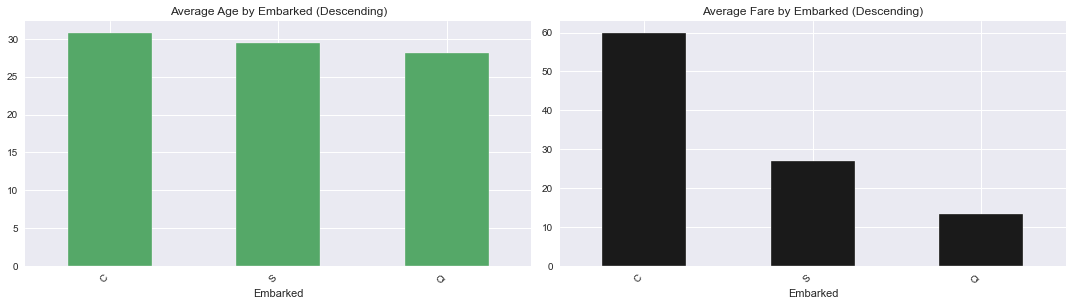

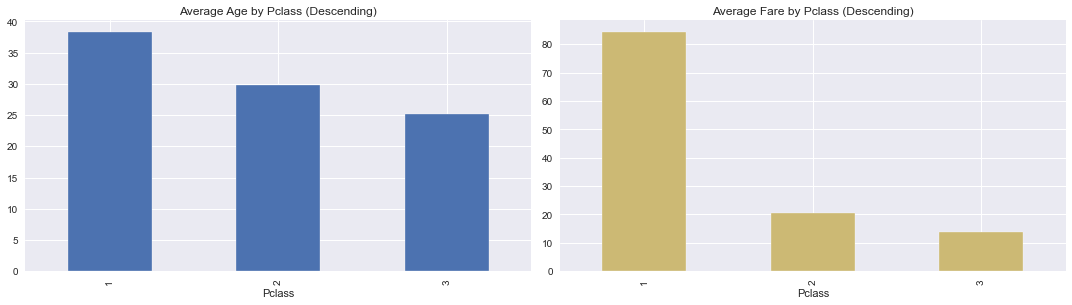

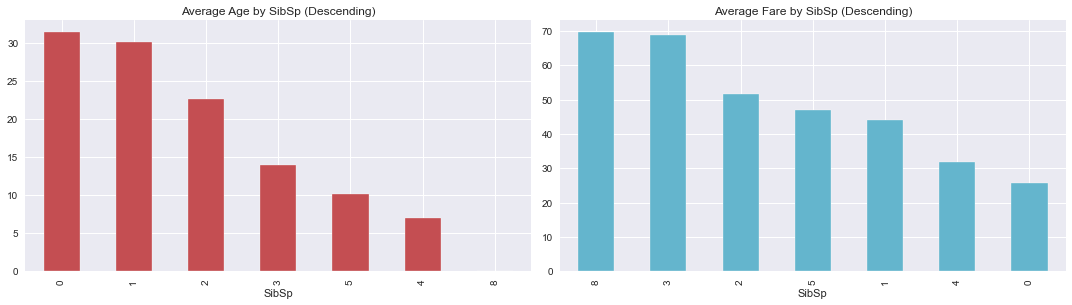

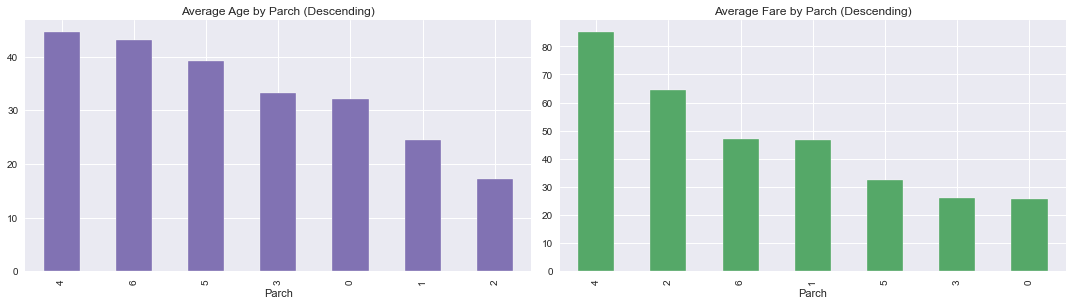

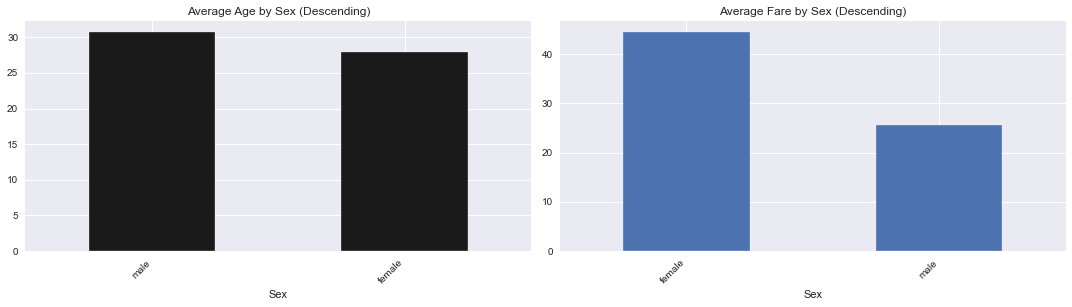

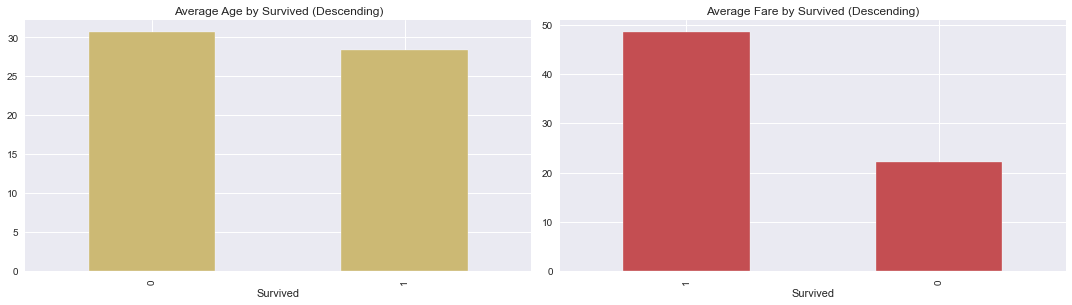

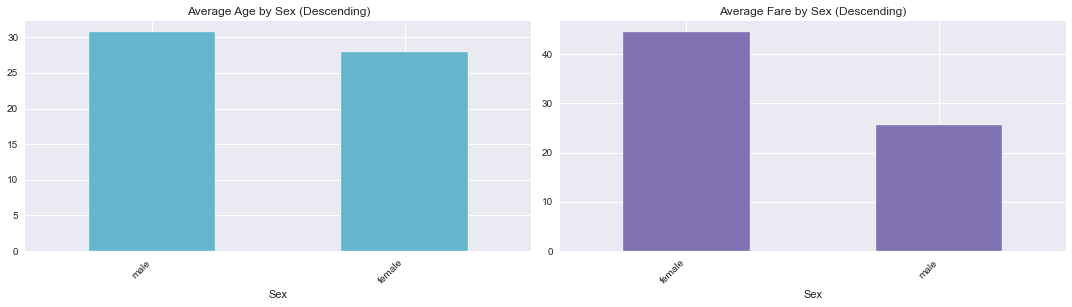

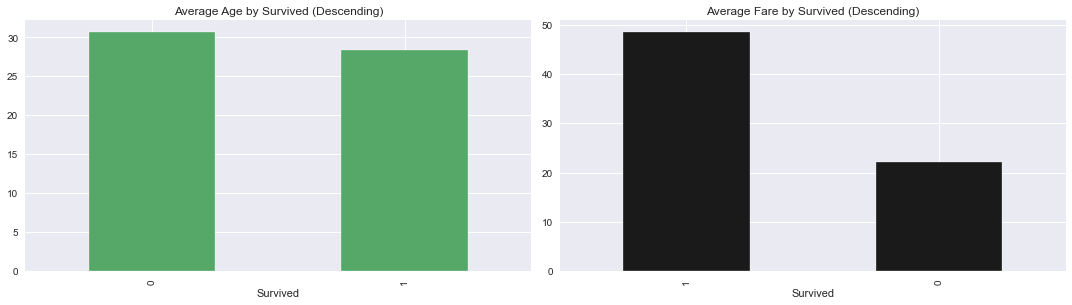

In [22]:
AV = AutoViz_Class()
report_2 = AV.AutoViz("dataset/train.csv")

# EDA
______________________________________________

We goint to explorate our data looking for relationships and some correlations with the survivors
* Missing Values
* Repeating values
* Histogram visualization (Normal distribution)
* Correlation into numerical data and survivors
* Barchar to visualize categorical data, to study the relevance of every category

###  EDA -  Missing Values

In [159]:
# Numerical Data
DBtrain.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [160]:
DBtrain.describe(include=['object'])

Name   Sex  Ticket    Cabin  \
count                                         891   891     891      204   
unique                                        891     2     681      147   
top     Dick, Mrs. Albert Adrian (Vera Gillespie)  male  347082  B96 B98   
freq                                            1   577       7        4   

       Embarked  
count       889  
unique        3  
top           S  
freq        644

Analising the data we can see that the categorical and numerical data are just like this

In [161]:
DBtrain_num = ['Age', 'SibSp', 'Parch', 'Fare']
DBtrain_cat = ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Survived','Pclass']

### EDA - Visualizing histograms for numerical data
We can see that, Age is pretty normalize, but SibSP, Parch concentrate values of zero(0) value, 
We can see that Fare haven't a normal distribution, but i think that i could normalize, apply some matematical operatión to his values

C:\Users\David\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\David\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


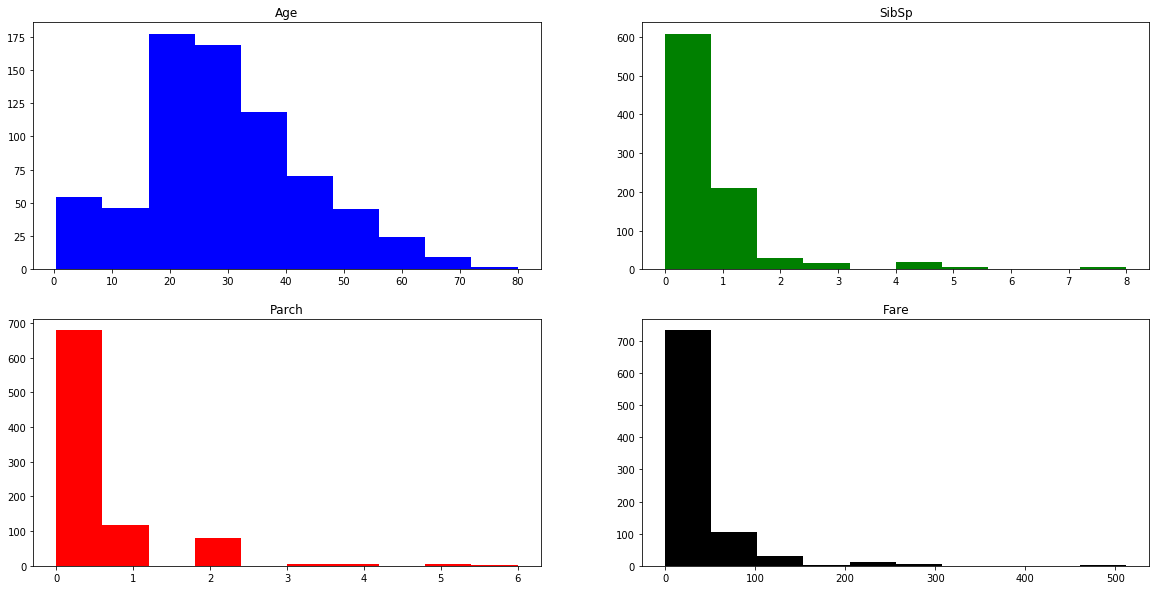

In [162]:
rcParams['figure.figsize'] = 20, 10
fig, axes = plt.subplots(nrows=2, ncols=2)
colors = ['b', 'g', 'r', 'k']
n_bins = None
for n, zippack in enumerate(zip(axes.flatten(), DBtrain_num)):
    axhist , i_label = zippack
    axhist.hist(DBtrain[i_label],bins=n_bins, histtype='bar',color=colors[n] ,density =None)
    axhist.set_title(i_label)

We can see that Age and Fare, have multiples values, maybe we can create bands of values and see probability behavior of sirvive

* We can create bands in Age, there are not a perfect lenght for discretize the Age, but 5 look pretty good, for diferenciate probalistic beteeen bands, more bands, generate almos equal probality in intemedian ages

AgeBand  PassengerId
0    (0, 16]          100
1   (16, 32]          346
2   (32, 48]          188
3   (48, 64]           69
4  (64, 100]           11

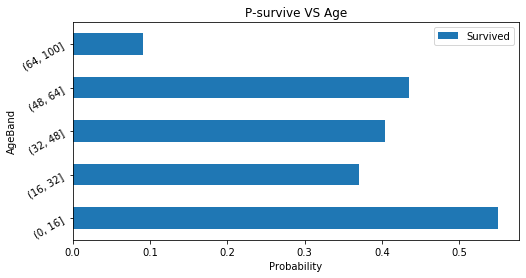

In [163]:
rcParams['figure.figsize'] = 8, 4
n_bins = 5
DBtrain['AgeBand'] = pd.cut(DBtrain['Age'], [min(0,DBtrain['Age'].min()),16,32,48,64,max(100,DBtrain['Age'].max())])
_ = DBtrain[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False ).mean().sort_values(by='AgeBand', ascending=True)
_.index = _['AgeBand']
_ = _.plot(kind='barh',rot =30)
_.set_xlabel('Probability')
_.set_title('P-survive VS Age')
DBtrain[['AgeBand', 'PassengerId']].groupby(['AgeBand'], as_index=False ).count().sort_values(by='AgeBand', ascending=True)

* We can analize Fare groups vs bands,

we can see clearly that more wealthy you are, more probability of survive, but around 170-426 the probability didn't change to much
But if we only use 3 bins, the difference increases drastically, we could see a rate ~ x2 for every range, i mean ~ 0.38, 0.65, 1 in p-survive, unfortunately who survive depend on the wealthiness.

FareBand  PassengerId
0    (-1, 85]          825
1   (85, 170]           46
2  (170, 256]           11
3  (256, 426]            6
4  (426, 600]            3

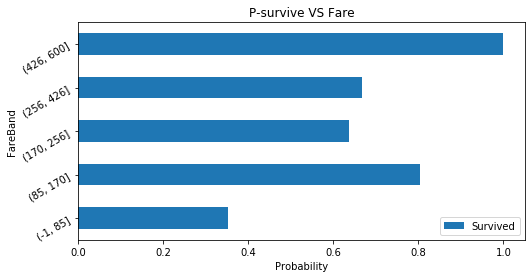

In [164]:
rcParams['figure.figsize'] = 8, 4
n_bins = 3
DBtrain['FareBand'] = pd.cut(DBtrain['Fare'], [min(-1,DBtrain['Fare'].min()),85,170,256,426,max(600,DBtrain['Fare'].max())])
#DBtrain['FareBand'] = pd.cut(DBtrain['Fare'], n_bins)
_ = DBtrain[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False ).mean().sort_values(by='FareBand', ascending=True)
_.index = _['FareBand']
_ = _.plot(kind='barh',rot =30)
_.set_xlabel('Probability')
_.set_title('P-survive VS Fare')
DBtrain[['FareBand', 'PassengerId']].groupby(['FareBand'], as_index=False ).count().sort_values(by='FareBand', ascending=True)

### EDA - Correlation between numerical features
From this study, we can infare that SibSp and Parch are a quite correlated, so we may fusion those variables into a single one, that indicate about, how alone or acoompained is a passenger, maybe infuence his survival

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


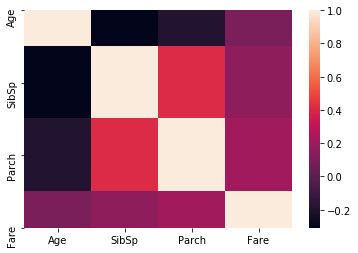

In [165]:
rcParams['figure.figsize'] = 6, 4
coor_matrix = DBtrain[DBtrain_num].corr()
print(coor_matrix)
_ = sns.heatmap(coor_matrix)

### EDA - Mean Values for every num_val VS Survived
We can see 
* more young more probability to survive
* more wealthy more chance to survive
* About Parch and SibSP is not so clear, but i think that is a little indicator to more parents more chance to live

In [166]:
pd.pivot_table(DBtrain, index= 'Survived',values= DBtrain_num,aggfunc=['mean' ])

mean                               
                Age       Fare     Parch     SibSp
Survived                                          
0         30.626179  22.117887  0.329690  0.553734
1         28.343690  48.395408  0.464912  0.473684

### EDA - Barchar for categorical Data
we can see<p>
-the population of male are more bigger that female<p>
-the embarker C is more frecuenly<p>
-the 3thr class is the mayority of the passenger<p>
-Ticket and Cabin are not grouped so they can't be categorized in his raw form<p>
-Imbalance data set to classify survivor, could produce imbalance model, 549 deads vs 342 survivors

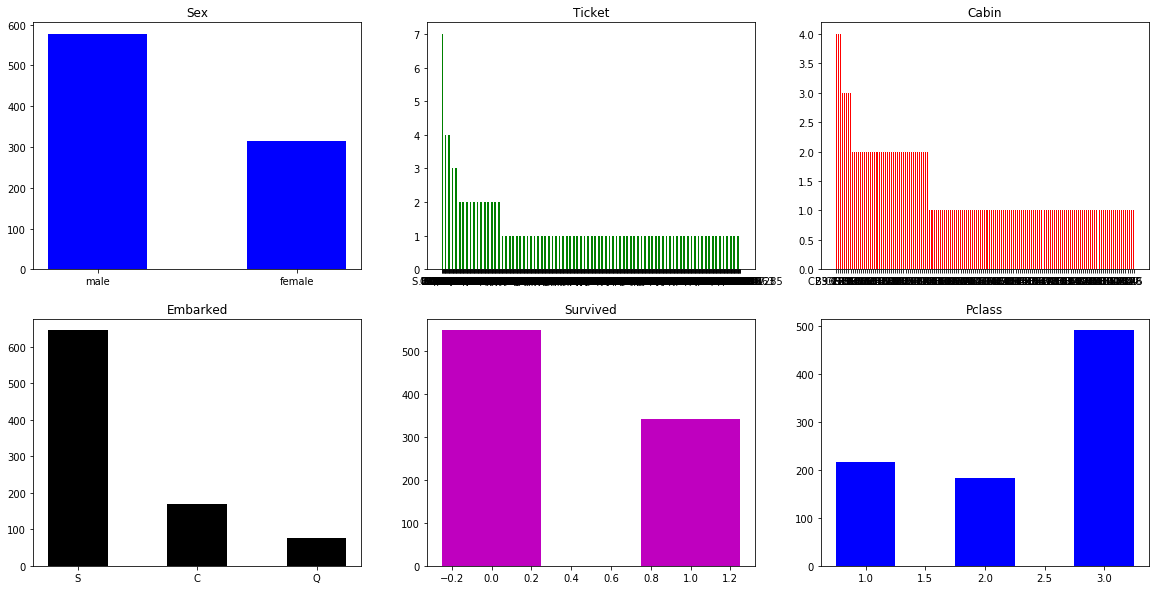

In [167]:
rcParams['figure.figsize'] = 20, 10
fig, axes = plt.subplots(nrows=2, ncols=3)
colors = ['b', 'g', 'r', 'k','m','b']
for n, zippack in enumerate(zip(axes.flatten(), DBtrain_cat)):
    axhist , i_label = zippack
    axhist.bar(DBtrain[i_label].value_counts().index.astype('object'), DBtrain[i_label].value_counts(),color=colors[n],width=0.5)
    axhist.set_title(i_label)

### EDA - Relationship between every categorical data and survival rate
We visualice some relation between survivers and his conditions in the journy
* Females survive more that males
* Embarker C have more survivors
* Class 1 have more survivors <p>

We may say that this result is because,
1. Money, Unfortunately is a factor
2. The place where they out,
3. "Women and children first" [wiki](https://en.wikipedia.org/wiki/Women_and_children_first)

          count
         Ticket
Survived       
0           549
1           342
            mean    count
        Survived Survived
Sex                      
female  0.742038      314
male    0.188908      577
              mean    count
          Survived Survived
Embarked                   
C         0.553571      168
Q         0.389610       77
S         0.336957      644
            mean    count
        Survived Survived
Pclass                   
1       0.629630      216
2       0.472826      184
3       0.242363      491


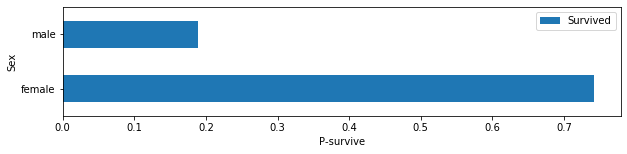

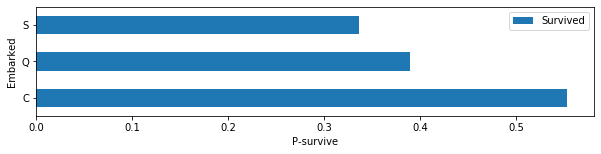

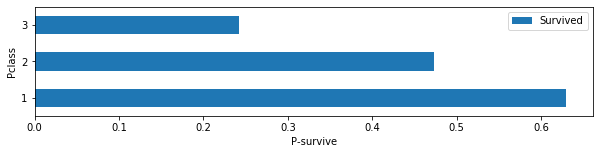

In [168]:

rcParams['figure.figsize'] = 10, 2
not_pivot = ['Survived','Ticket', 'Cabin' ]
_ = pd.pivot_table(DBtrain, index= 'Survived',values= 'Ticket',aggfunc=['count'])
print(_)
for i_label in DBtrain_cat:
    if i_label not in not_pivot:
        _ = pd.pivot_table(DBtrain, index= i_label,values= 'Survived',aggfunc=['mean','count'])
        print(_)
        _ =_['mean'].plot(kind='barh')
        _.set_xlabel('P-survive')

# FE - Feature Engineering
___________________________

#### Augmented Features
* Create a new feature from study Parch and SibSp
* Transform cabin string feature into a number that represent how many cabins a passager bought
* Take more features, asumming that one person bought all cabin with the same firts word, so we can know what "cabin Type" bought a passenger
* Take more features from the "Name" feature, we goint to see if the title name is relevant to determine if someone survive
* Study the posibility to extract some features form "Ticket"
* Fill nan values
* Normalizing Data
________________________________

### FE - Create a new feature from study Parch and SibSp
Just like we say in EDA, we can see a correlatión between Parch and SibSp, so we can create a single feature that resumen and could be more afective.

We know that bouth feature are relatave with how much familiar companied do you have in the ship, so we can summaize bouth feature into just one.

In [169]:
DBtrain['n_parents'] = DBtrain['SibSp'] + DBtrain['Parch']
_ = pd.pivot_table(DBtrain, columns= 'n_parents', index= 'Survived',values= 'PassengerId',aggfunc='count')
print(_)

n_parents     0     1     2     3     4     5    6    7    10
Survived                                                     
0          374.0  72.0  43.0   8.0  12.0  19.0  8.0  6.0  7.0
1          163.0  89.0  59.0  21.0   3.0   3.0  4.0  NaN  NaN


We see so many categories that destroy visivility, so we try transforming all categories into just 2, or you are accompanied or alone.
* if you are accompanied your chances to survive increase around to 50%


In [170]:
DBtrain['accompanied'] = DBtrain['n_parents'].apply(lambda x: 1 if x >0 else 0)
_ = pd.pivot_table(DBtrain, columns= 'accompanied', index= 'Survived',values= 'PassengerId',aggfunc='count')
print(_)

accompanied    0    1
Survived             
0            374  175
1            163  179


### FE - Exploring what is Cabin, 
we can see that not everyone buy for a cabin, but some wealthy people bought more than one cabin

We can denote that the name of the cabins dosen't matter. I think that only mather the quantity of cabin that a people buy,
that could be related whit his wealthiness.
For other hand, we can study that the first letter, in the cabin nam, have some importance over the survivors, maybe its location on the ship

In [171]:
_=DBtrain['Cabin'].value_counts().sort_values(ascending=False )
print(_.shape)
print(_)
# Count how many cabins a passenger bought
DBtrain['Count_Cabin'] = DBtrain['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
#DBtrain['Count_Cabin'].value_counts()

# Categorizing which type of cabin a passenger bought
DBtrain['w_Cabin'] = DBtrain['Cabin'].apply(lambda x: 'nn' if pd.isna(x) else x[0])
#DBtrain['w_Cabin'].value_counts() 

(147,)
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F2             3
              ..
D30            1
C106           1
C103           1
A23            1
A20            1
Name: Cabin, Length: 147, dtype: int64


We see that the way majority of the passenger not buy a single Cabin, so now we pretend to categorice the cabins, this will create impresaisly data to the model, instead we could only extract to categories, 
* The passenger bought or not a cabin

In [172]:
# We will see the relationship between survivors and the number of cabin that bought
_ = pd.pivot_table(DBtrain, columns= 'Count_Cabin', index= 'Survived',values= 'Ticket',aggfunc='count')
print(_)
print("______________________")
# we will see the relationship between survivors and the type of cabin that they bought
_ = pd.pivot_table(DBtrain, columns= 'w_Cabin', index= 'Survived',values= 'Ticket',aggfunc='count')
print(_)

Count_Cabin      0      1    2    3    4
Survived                                
0            481.0   58.0  7.0  3.0  NaN
1            206.0  122.0  9.0  3.0  2.0
______________________
w_Cabin     A     B     C     D     E    F    G    T     nn
Survived                                                   
0         8.0  12.0  24.0   8.0   8.0  5.0  2.0  1.0  481.0
1         7.0  35.0  35.0  25.0  24.0  8.0  2.0  NaN  206.0


* The passenger bought a cabin yes or not

In [173]:
# The passenger bought a cabin yes or not
DBtrain['b_Cabin'] = DBtrain['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
_ = pd.pivot_table(DBtrain, columns= 'b_Cabin', index= 'Survived',values= 'Ticket',aggfunc='count')
print(_)

b_Cabin     0    1
Survived          
0         481   68
1         206  136


### FE - Extracting features from Name
We going to extract the name title from every passenger, I think that is relative with his social posición and his gender, maybe is a condition that affect his survival

We see that exist 4 predominant titles name, so can group all passanger into this group, changing the less predomint to others

In [174]:
DBtrain['title_Name'] = DBtrain['Name'].apply(lambda x: x.split(',')[1:][0].split('.')[0].strip())
DBtrain['title_Name'].value_counts() 

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Jonkheer          1
Capt              1
Mme               1
Sir               1
the Countess      1
Lady              1
Ms                1
Don               1
Name: title_Name, dtype: int64

In [175]:
# Grouping title names using only the predominants
title_pred = ['Mr', 'Miss', 'Mrs']
DBtrain['title_Name'] = DBtrain['title_Name'].apply(lambda x: x if x in title_pred else 'Others')
print(DBtrain['title_Name'].value_counts() )
_ = pd.pivot_table(DBtrain, columns= 'title_Name', index= 'Survived',values= 'PassengerId',aggfunc='count')
print(_)

Mr        517
Miss      182
Mrs       125
Others     67
Name: title_Name, dtype: int64
title_Name  Miss   Mr  Mrs  Others
Survived                          
0             55  436   26      32
1            127   81   99      35


### FE - Studing the Ticket
I studied the numerical and the no numerical mix Ticket, and try to find some relation in survival rate, but we found that is too random to be useful. I decided to drop that feature.

In [176]:
# We goint to pretend that there is a relatión between the ticket ID and the survivors
#   We take two new features
#      1. If a ticket is a number, take the logarithm10 round to whole
#      2. If a ticket start with a letter, take that string of letters. This technique is so risky, because in our test set could be a new string and will be in trouble
countbyTicket = DBtrain['Ticket'].value_counts()#.sort_values(ascending = False)
DBtrain['num_Ticket'] = DBtrain['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)
DBtrain['word_Ticket'] = DBtrain['Ticket'].apply(lambda x: x.split(' ')[0].replace('.', '').replace('/','').lower() if not x.split(' ')[0].isnumeric() else 0)
print(DBtrain['num_Ticket'].value_counts())
print(DBtrain['word_Ticket'].value_counts())
_ = pd.pivot_table(DBtrain, columns= 'num_Ticket', index= 'Survived',values= 'Ticket',aggfunc='count')
print(_)
_ = pd.pivot_table(DBtrain, columns= 'word_Ticket', index= 'Survived',values= 'Ticket',aggfunc='count')
print(_)

1    661
0    230
Name: num_Ticket, dtype: int64
0          661
pc          60
ca          41
a5          21
sotonoq     15
stono       12
scparis     11
wc          10
a4           7
soc          6
stono2       6
fcc          5
c            5
line         4
sopp         3
scah         3
wep          3
pp           3
swpp         2
sotono2      2
ppp          2
sc           1
fc           1
casoton      1
sp           1
sca4         1
fa           1
scow         1
sop          1
as           1
Name: word_Ticket, dtype: int64
num_Ticket    0    1
Survived            
0           142  407
1            88  254
word_Ticket      0   a4    a5   as    c    ca  casoton   fa   fc  fcc  ...  \
Survived                                                               ...   
0            407.0  7.0  19.0  1.0  3.0  27.0      1.0  1.0  1.0  1.0  ...   
1            254.0  NaN   2.0  NaN  2.0  14.0      NaN  NaN  NaN  4.0  ...   

word_Ticket  sop  sopp  sotono2  sotonoq   sp  stono  stono2  swpp   wc 

 We can't see any relationship, even those repeat more than 20%
 * We can drop Ticket Feature

In [177]:
DBtrain=DBtrain.drop(columns=['Ticket','num_Ticket','word_Ticket'])

### FE - Fill Nan values
Like humans we can't see the whole data in a single look, to achieve we aggregate data, reading the count, uniquisity and distribution behavior of the data.

That exactly what we goint to do next

* Behavior of categorical data

In [178]:
DBtrain.describe(include=['object','category'])

Name   Sex    Cabin Embarked  \
count                                         891   891      204      889   
unique                                        891     2      147        3   
top     Dick, Mrs. Albert Adrian (Vera Gillespie)  male  B96 B98        S   
freq                                            1   577        4      644   

         AgeBand  FareBand w_Cabin title_Name  
count        714       891     891        891  
unique         5         5       9          4  
top     (16, 32]  (-1, 85]      nn         Mr  
freq         346       825     687        517

* Behavior of numerical data
    * we detect that Some values of Fare are 0 ¿? could be an error or a gifs

In [179]:
DBtrain.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare   n_parents  accompanied  Count_Cabin  \
count  891.000000  891.000000  891.000000   891.000000   891.000000   
mean     0.381594   32.204208    0.904602     0.397306     0.267116   
std      0.806057   49.693429    1.613459     0.489615     0.547134   
min      0.000000    0.000000    0.000000     0.000000     0.000000   
25%      0.000000    7.910400    0.000000     0.000000     0.000000   
50%      0.000000   14.454200    0.000000     0.000000     0.000000   
75%      0.000000   31.000000    1.000000     1.000000     0.000000   
max      6.000000  512.329200   10.000000     1.000000     4.000000   

          b_Cabin  
count  891.000000  
mean     0.228956  
std      0.420397  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000

* We see that AGe have Nan values, so we have to impute data (mean)
* We see thar Embarked have Nan Values, so we have to imute data categorical (moda)
* Cabin habe only 204 values, but we already study this feature

In [180]:
DBtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
AgeBand        714 non-null category
FareBand       891 non-null category
n_parents      891 non-null int64
accompanied    891 non-null int64
Count_Cabin    891 non-null int64
w_Cabin        891 non-null object
b_Cabin        891 non-null int64
title_Name     891 non-null object
dtypes: category(2), float64(2), int64(9), object(6)
memory usage: 120.7+ KB


* Age => complete the nan values with mean value
* Embarked => Complete the nan values with the mode, which is S

In [181]:
DBtrain['Embarked'].mode()[0]

'S'

We take the media value using Sex and Pclass, to fill the nan values in Age feature

In [72]:
media_age = DBtrain.dropna(subset=['Age'])[['Age','Pclass','Sex']].groupby(['Pclass', 'Sex'], as_index=False ).mean().sort_values(by='Age', ascending=True)
def impute_years(x):
    if x['Age'] == x['Age'] :
        return x['Age']
    else:
        return media_age.loc[media_age['Pclass']==x['Pclass'] , ['Age', 'Sex']].loc[media_age['Sex']==x['Sex'] , ['Age']]['Age'].tolist()[0]


In [182]:
DBtrain['Embarked'] = DBtrain['Embarked'].fillna(DBtrain['Embarked'].mode()[0])
DBtrain['Age'] = DBtrain.apply(impute_years, axis=1)# DBtrain['Age'].fillna( DBtrain['Age'].mean())
DBtrain['AgeBand'] = pd.cut(DBtrain['Age'], [min(0,DBtrain['Fare'].min()),16,32,48,64,max(100,DBtrain['Age'].max())])
DBtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
AgeBand        891 non-null category
FareBand       891 non-null category
n_parents      891 non-null int64
accompanied    891 non-null int64
Count_Cabin    891 non-null int64
w_Cabin        891 non-null object
b_Cabin        891 non-null int64
title_Name     891 non-null object
dtypes: category(2), float64(2), int64(9), object(6)
memory usage: 120.7+ KB


### FE - Normalizing Data
We saw that we could normalize the fare value, so we will try take the log10 to the fare value and see how it behaves

The transform result pretty useful, delivering a good normal distributión

Text(0.5, 1.0, 'Fare normalized')

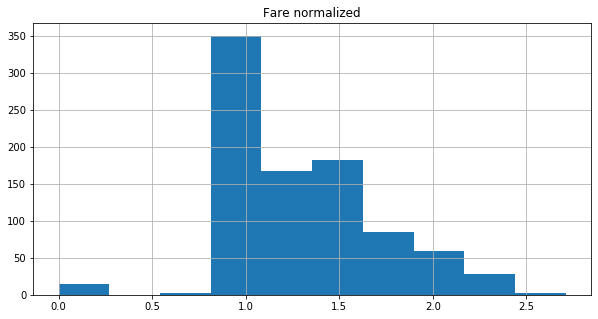

In [191]:
# On "Histogram for numerical Data" we saw that "Fare" is not normalize, the distance between his values are significance
#     We try to normalize that data, taken the logarithm10 to those values
rcParams['figure.figsize'] = 10, 5
DBtrain['norm_Fare']= DBtrain['Fare'].apply(lambda x : np.log10(x+1))
#DBtrain['norm_Fare']= DBtrain['norm_Fare']
DBtrain['norm_Fare'].hist().set_title('Fare normalized')
# we can see that the histogram look like a normal distributions more accurate

# Pre-processing data to Train Models
Because we have categorical data, we need to transform all the categorical data into arrays that our model can interpretate,
we can use pd.dummies or hot-encode, in this case are equal, also we need to drop the columns that we dont use anymore

In [184]:
DBtrain.head(2)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Fare Cabin Embarked   AgeBand  FareBand  n_parents  accompanied  \
0      0   7.2500   NaN        S  (16, 32]  (-1, 85]          1            1   
1      0  71.2833   C85        C  (32, 48]  (-1, 85]          1            1   

   Count_Cabin w_Cabin  b_Cabin title_Name  norm_Fare  
0            0      nn        0         Mr   0.001789  
1            1       C        1        Mrs   0.003629

* Data set modeling with all feature categorical

In [185]:
# Second Test
DBtrain_f = DBtrain.copy()
DBtrain_f.index  = DBtrain_f.PassengerId
DBtrain_f = DBtrain_f.drop(columns=[ 'Cabin','Fare','Name','PassengerId','w_Cabin', 'Count_Cabin','n_parents','SibSp','Parch','norm_Fare', 'Age'])
DBtrain_f['Pclass'] = DBtrain_f['Pclass'].astype(str) # categorical feature
DBtrain_f['accompanied'] = DBtrain_f['accompanied'].astype(str) # categorical feature
DBtrain_f['b_Cabin'] = DBtrain_f['b_Cabin'].astype(str) # categorical feature
DBtrain_f['AgeBand'] = DBtrain_f['AgeBand'].astype(str) # categorical feature
DBtrain_f['AgeBand'] = DBtrain_f['AgeBand'].apply(lambda x : x.replace('(','').replace(']','').replace(',','_'))
DBtrain_f['FareBand'] = DBtrain_f['FareBand'].astype(str) # categorical feature
DBtrain_f['FareBand'] = DBtrain_f['FareBand'].apply(lambda x : x.replace('(','').replace(']','').replace(',','_'))
DBtrain_f.info()
DBtrain_f.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
Survived       891 non-null int64
Pclass         891 non-null object
Sex            891 non-null object
Embarked       891 non-null object
AgeBand        891 non-null object
FareBand       891 non-null object
accompanied    891 non-null object
b_Cabin        891 non-null object
title_Name     891 non-null object
dtypes: int64(1), object(8)
memory usage: 69.6+ KB


Survived Pclass     Sex Embarked AgeBand FareBand accompanied  \
PassengerId                                                                  
1                   0      3    male        S  16_ 32   -1_ 85           1   
2                   1      1  female        C  32_ 48   -1_ 85           1   
3                   1      3  female        S  16_ 32   -1_ 85           0   
4                   1      1  female        S  32_ 48   -1_ 85           1   
5                   0      3    male        S  32_ 48   -1_ 85           0   

            b_Cabin title_Name  
PassengerId                     
1                 0         Mr  
2                 1        Mrs  
3                 0       Miss  
4                 1        Mrs  
5                 0         Mr

* Data set modeling with Age and Fare like numerical feature

In [193]:
# First test
DBtrain_f = DBtrain.copy()
DBtrain_f.index  = DBtrain_f.PassengerId
DBtrain_f = DBtrain_f.drop(columns=[ 'Cabin','Fare','Name','PassengerId','w_Cabin', 'Count_Cabin','n_parents','SibSp','Parch','AgeBand','FareBand' ])
DBtrain_f['Pclass'] = DBtrain_f['Pclass'].astype(str) # categorical feature
DBtrain_f['accompanied'] = DBtrain_f['accompanied'].astype(str) # categorical feature
DBtrain_f['b_Cabin'] = DBtrain_f['b_Cabin'].astype(str) # categorical feature
DBtrain_f.info()
DBtrain_f.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
Survived       891 non-null int64
Pclass         891 non-null object
Sex            891 non-null object
Age            891 non-null float64
Embarked       891 non-null object
accompanied    891 non-null object
b_Cabin        891 non-null object
title_Name     891 non-null object
norm_Fare      891 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 69.6+ KB


Survived Pclass     Sex   Age Embarked accompanied b_Cabin  \
PassengerId                                                               
1                   0      3    male  22.0        S           1       0   
2                   1      1  female  38.0        C           1       1   
3                   1      3  female  26.0        S           0       0   
4                   1      1  female  35.0        S           1       1   
5                   0      3    male  35.0        S           0       0   

            title_Name  norm_Fare  
PassengerId                        
1                   Mr   0.916454  
2                  Mrs   1.859038  
3                 Miss   0.950608  
4                  Mrs   1.733197  
5                   Mr   0.956649

In [194]:
DBtrain_f = pd.get_dummies(DBtrain_f)
X_train = DBtrain_f.drop(columns='Survived')
Y_train = DBtrain_f['Survived']
DBtrain_f.head()

Survived   Age  norm_Fare  Pclass_1  Pclass_2  Pclass_3  \
PassengerId                                                            
1                   0  22.0   0.916454         0         0         1   
2                   1  38.0   1.859038         1         0         0   
3                   1  26.0   0.950608         0         0         1   
4                   1  35.0   1.733197         1         0         0   
5                   0  35.0   0.956649         0         0         1   

             Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
PassengerId                                                             
1                     0         1           0           0           1   
2                     1         0           1           0           0   
3                     1         0           0           0           1   
4                     1         0           0           0           1   
5                     0         1           0           0           1   

             accompanied_0  accompanied_1  b_Cabin_0  b_Cabin_1  \
PassengerId                                                       
1                        0              1          1          0   
2                        0              1          0          1   
3                        1              0          1          0   
4                        0              1          0          1   
5                        1              0          1          0   

             title_Name_Miss  title_Name_Mr  title_Name_Mrs  title_Name_Others  
PassengerId                                                                     
1                          0              1               0                  0  
2                          0              0               1                  0  
3                          1              0               0                  0  
4                          0              0               1                  0  
5                          0              1               0                  0

# Modeling - Improve imbalance data
we goint to see how well BalancedBaggingClassifier, we improve the model with imbalance method training
* 549 deads vs 342 survivors

| Model  | score  | 
|---|---|
| SVC  |    0.8907 |  
| XGB  | 0.8843 | 
| KNC  |   0.9335|
| RFC |    0.9690 |
| Voting XGB+KNC+RFC| 0.9526| 

In [3]:
X_train, Y_train = pre_process_dataset(all_categorical=False, Test=False, fillna_age = None)
X_train, Y_train = balancingClasses_Smote(X_train, Y_train ,random_state=12)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
Survived       891 non-null int64
Pclass         891 non-null object
Sex            891 non-null object
Age            891 non-null float64
Embarked       891 non-null object
accompanied    891 non-null object
b_Cabin        891 non-null object
title_Name     891 non-null object
norm_Fare      891 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 69.6+ KB
Count for each class value after SMOTE: Counter({0: 549, 1: 549})


* SVC + BalancedBaggingClassifier

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]SVM: acc:0.8907103825136612


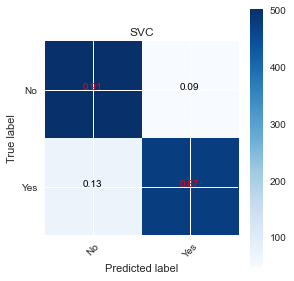

In [4]:
#Modelo with SVC
clf = svm.SVC(verbose= True,random_state=5,C=10, kernel='rbf',degree=3, gamma='auto',probability=True)
clf = BalancedBaggingClassifier(base_estimator=clf,
                                sampling_strategy='auto',
                                replacement=False,random_state=42)
fit_model = clf.fit(X_train, Y_train)
y_pred = clf.predict(X_train)
print("SVM: acc:"+ str(accuracy_score(Y_train, y_pred)))
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred, class_names=['No', 'Yes'],title="SVC",normalize=True, size=4)

* XGB + BalancedBaggingClassifier

XGB: acc:0.8843351548269581


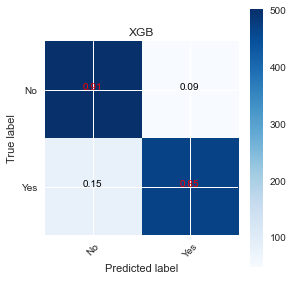

In [5]:
xgb_model_ = XGBClassifier(learning_rate=0.01,
                    n_estimators=80, #150
                    max_depth=100,
                    min_child_weight=.05,
                    gamma=0,
                    subsample=.5,
                    colsample_bytree=0.5,
                    objective='binary:logistic',#'multi:softmax',num_class=10,
                    num_parallel_tree = 8,
                    seed=27,verbosity= 1,n_jobs=8 )
xgb_model = BalancedBaggingClassifier(base_estimator=xgb_model_,
                                sampling_strategy='auto',
                                replacement=False,random_state=42)
xgb_model.fit(X_train, Y_train)
#xgb_model.save_model('models/xgbmodel')
y_pred = xgb_model.predict(X_train)
print("XGB: acc:"+ str(accuracy_score(Y_train, y_pred)))
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred, class_names=['No', 'Yes'],title="XGB",normalize=True, size=4)

* KNC + BalancedBaggingClassifier

KNC: acc:0.9335154826958105


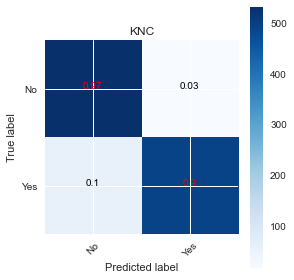

In [6]:
clf_KNC_ = KNC(n_neighbors=2,n_jobs=-1,algorithm='brute',p=2 )
clf_KNC = BalancedBaggingClassifier(base_estimator=clf_KNC_,
                                sampling_strategy='auto',
                                replacement=False,random_state=42)
clf_KNC.fit(X_train, Y_train)
y_pred = clf_KNC.predict(X_train)
print("KNC: acc:"+ str(accuracy_score(Y_train, y_pred)))
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred, class_names=['No', 'Yes'],title="KNC",normalize=True,size=4)

* RFC + BalancedBaggingClassifier

RFC: acc:0.9690346083788707


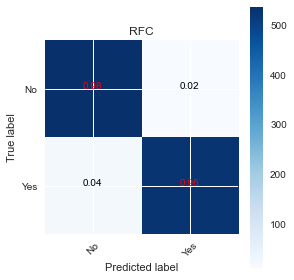

In [7]:
clf_RFC_ = RandomForestClassifier( n_estimators=80, n_jobs=-1)# 20 - 80
clf_RFC = BalancedBaggingClassifier(base_estimator=clf_RFC_,
                                sampling_strategy='auto',
                                replacement=False,random_state=42)
clf_RFC.fit(X_train, Y_train)
y_pred = clf_RFC.predict(X_train)
print("RFC: acc:"+ str(accuracy_score(Y_train, y_pred)))
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred, class_names=['No', 'Yes'],title="RFC",normalize=True,size=4)

* VotingClassifier = XGB+KNC+RFC

VotingClassifier: acc:0.9526411657559198


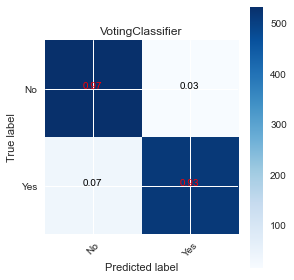

In [8]:
model_VC = VotingClassifier (estimators=[ ('xgb', xgb_model), ('knc', clf_KNC),('rfc',clf_RFC)], voting='hard', weights=[1,1,1],n_jobs=-1)
model_VC.fit(X_train, Y_train)
y_pred = model_VC.predict(X_train)
print("VotingClassifier: acc:"+ str(accuracy_score(Y_train, y_pred)))
plot_confusion_matrix(y_true=Y_train, y_pred=y_pred, class_names=['No', 'Yes'],title="VotingClassifier",normalize=True,size=4)

# Test perform
The test data contain Nans so, what i did was impute values, using the media, taking in consideration, Pclass, sex and Embarked
* Method below
* I create the file process_data.py where is the steps that i use for process all the test_Data

* Method to impute values to Age

In [9]:
media = DBtrain[['Age','Pclass','Sex','Embarked']].groupby(['Pclass', 'Sex','Embarked'], as_index=False ).mean().sort_values(by='Pclass', ascending=True)
media

Pclass     Sex Embarked        Age
0        1  female        C  36.052632
1        1  female        Q  33.000000
2        1  female        S  32.704545
3        1    male        C  40.111111
4        1    male        Q  44.000000
5        1    male        S  41.897188
11       2    male        S  30.875889
10       2    male        Q  57.000000
9        2    male        C  25.937500
8        2  female        S  29.719697
7        2  female        Q  30.000000
6        2  female        C  19.142857
12       3  female        C  14.062500
13       3  female        Q  22.850000
14       3  female        S  23.223684
15       3    male        C  25.016800
16       3    male        Q  28.142857
17       3    male        S  26.574766

In [10]:
def impute_years(x):
    if x['Age'] == x['Age']:
        return x['Age']
    else:
        return media.loc[media['Pclass']==x['Pclass'] , ['Age', 'Sex','Embarked']].loc[media['Sex']==x['Sex'] , ['Age','Embarked']].loc[media['Embarked']==x['Embarked'] , ['Age']]['Age'].tolist()[0]
X_age = DBtrain.apply(impute_years, axis=1)                                                                                                                          

* Preprocessing Test data to submmit

In [11]:
#from process_data import pre_process_dataset
X_test, X_test_origin = pre_process_dataset(all_categorical=False, Test=True, fillna_age = None)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
Pclass         418 non-null object
Sex            418 non-null object
Age            418 non-null float64
Embarked       418 non-null object
accompanied    418 non-null object
b_Cabin        418 non-null object
title_Name     418 non-null object
norm_Fare      418 non-null float64
dtypes: float64(2), object(6)
memory usage: 29.4+ KB


In [12]:
estmt = model_VC.estimators
y_predict_svc = clf.predict(X_test)
y_predict_xgb = estmt[0][1].predict(X_test)
y_predict_knc = estmt[1][1].predict(X_test)
y_predict_rfc = estmt[2][1].predict(X_test)
y_predict_vc = model_VC.predict(X_test)

In [16]:
print("CLASSIF test: equal:"+ str(accuracy_score(y_predict_svc, y_predict_vc)))

CLASSIF test: equal:0.9090909090909091


In [18]:
submission_file = pd.DataFrame({ 'PassengerId':np.stack(X_test.index.tolist()),'Survived': y_predict_vc})
submission_file.to_csv('submission/submm_vc4.csv',index=False, )
submission_file = pd.DataFrame({ 'PassengerId':np.stack(X_test.index.tolist()),'Survived': y_predict_xgb})
submission_file.to_csv('submission/submm_xgb4.csv',index=False, )
submission_file = pd.DataFrame({ 'PassengerId':np.stack(X_test.index.tolist()),'Survived': y_predict_knc})
submission_file.to_csv('submission/submm_knc4.csv',index=False, )
submission_file = pd.DataFrame({ 'PassengerId':np.stack(X_test.index.tolist()),'Survived': y_predict_rfc})
submission_file.to_csv('submission/submm_rfc4.csv',index=False, )